# Grover part 2

### Contents

1. [Iterations of Grover's algorithm](#iga)
2. [Grover's algorithm with multiple solutions](#mga)
3. [Advanced circuits](#ac)
    1. [Opaque gates and composite gates](#ogcg)
    2. [Parameterised gates](#parag)


In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

# Import math Library
import math 

## 1. Iterations of Grover's algorithm <a id="iga"></a>

Let's look closer to the number of iterations in the previous examples. 

First recall last class examples.
* In the first case, we have a list with **$4$ items**, and we want to **find $1$** specific element.
* In the seconde case, there have a list with **$8$ items**, and again we want to find just $1$ element. 

Despite knowing that to find the marked item in need roughly $\sqrt{N}$ iterations, we only use one iteration in each example. 

#### So, what is the optimal number of iteration for a problem with $N$ elemts and $M$ valid solutions?

Lets start to consider the superposition of all states that are not the solution:

$$|s'\rangle = \frac{1}{\sqrt{N-M}}\sum_{x:f(x)=0} |x\rangle $$

and the superposition of all states that are the solution:

$$|\omega \rangle = \frac{1}{\sqrt{M}}\sum_{x:f(x)=0} |x\rangle$$

The initial state of Grover's interation creates the state: 

$$|s\rangle = \sqrt{\frac{M}{N}}|\omega\rangle + \sqrt{\frac{N-M}{N}}|s'\rangle$$

Recall the geometric representation of the oracle and the difuser step. 

![geo](https://learn.microsoft.com/en-us/azure/quantum/media/grovers-iteration.png)

In the figure above $|all\rangle$, $|good\rangle$, $|bad\rangle$, and $|register\rangle$ correspond to $|s\rangle$ , $|\omega\rangle$ , $|s'\rangle$, $|\psi_t\rangle$  from the previous class, respectively.  

$\theta$ is just the angle between $|s\rangle$ and $|s'\rangle$ one can use the scalar product to find the angle. We know that $\cos\theta=\langle s|s'\rangle$, so one needs to calculate $\langle s|s'\rangle$. 
From the decomposition of $|s\rangle$ in terms of the states $|\omega \rangle$ and $|s'\rangle$, we have:

$$\theta =\arccos(\langle s|s'\rangle) = \arccos{\sqrt{\frac{N-M}{N}}}$$

The angle between the our state and the $|\omega\rangle$ state decreases with each iteration, resulting in a higher probability of measuring a valid result. 
The goal is to ensure that the angle between $|\omega\rangle$ and $|\psi_t\rangle$ is close to $\frac{\pi}{2}$. We will cal the angle $\theta_t$, where $t$ is the iteration count:

$$ \theta_t = (2 t + 1) \theta $$

As the probability of success can be written as a function of the number of iterations, the optimal number of iterations $t_{optimal}$ can be found by computing the smallest positive integer that (approximately) maximizes the success probability function.

![iterations](https://learn.microsoft.com/en-us/azure/quantum/media/success-probability-grovers.png)

We know that $\sin^2x$ reaches its first maximum for $x=\frac{\pi}{2}$, so:

$$\frac{\pi}{2} =(2t_{optimal}+1) \theta = (2t_{optimal} +1) \arccos{\sqrt{\frac{N-M}{N}}}$$

<div class="alert alert-block alert-warning">

Calculate the optimal number of iteration ($t_{optimal}$) for the previous examples. 
1. In the first case, we have a list with **$4$ items**, and we want to **find $1$** specific element.
2. In the seconde case, there have a list with **$8$ items**, and again we want to find just $1$ element. 
     
</div>

In [49]:
from math import pi, acos, sqrt
def it(n,m):
    return round(((pi/2)/acos(sqrt((n-m)/n)) - 1)/2)

In [54]:
it(16,2)

2

<div class="alert alert-block alert-warning">

Consider the situation $m=\frac{n}{2}$. 
    
Can you explain what complications you may find in such situation?
</div>

## 2. Grover's algorithm with multiple solutions <a id="mga"></a>

The goal now is to solve a simple problem using Grover's algorithm. Our problem is a $2\times2$ binary sudoku, which in our example has two simple rules:

* No column may contain the same value twice
* No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![sudoku](https://qiskit.org/textbook/ch-algorithms/images/binary_sudoku.png)

We want our circuit to output a solution to this sudoku.

This problem has $N=16$ elements and $M=2$ solutions. 

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

* v0 ≠ v1  -  check along top row
* v2 ≠ v3  -  check along bottom row
* v0 ≠ v2  -  check down left column
* v1 ≠ v3  -  check down right column

We are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [9]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. To check these clauses computationally, we will use the XOR gate.

|a|b|output|
|-|-|-|
|0|0|0|
|0|1|1|
|1|0|1|
|1|1|0|

This way the `output0` bit in the circuit below will only be flipped if `input0 ≠ input1`:

<div class='alert alert-block alert-warning'>
    Define XOR function.
</div>

In [10]:
# qc - quantum circuit
# a,b - inputs
# output

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

# v0 .
# v1 | .
# v2 | |
# v3 | |
# C0 X X
# C1
# C2
# C3


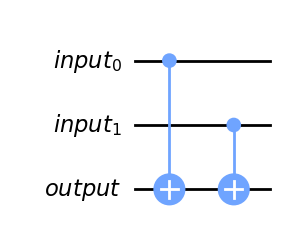

In [11]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw('mpl')

To check each clause, we repeat this circuit for each pairing in clause_list and store the output to a new bit:

<div class='alert alert-block alert-warning'>
    Complete the following step.
</div>

0 [0, 1]
1 [0, 2]
2 [1, 3]
3 [2, 3]


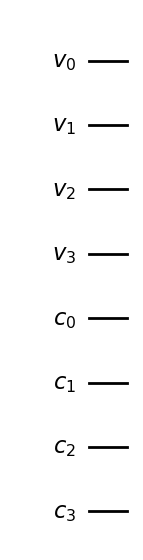

In [98]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
for i, clause in enumerate(clause_list):
    XOR(qc, var_qubits[clause[0]], var_qubits[clause[1]], clause_qubits[i])


qc.draw('mpl')

The final state of the bits `c0, c1, c2, c3` will only all be 1 in  case  the assignments of `v0, v1, v2, v3` are a solution to the sudoku. To complete our checking circuit, we want a single bit to be 1 if (and only if) all the clauses are satisfied, this way, we can look at just one bit to see if our assignment is a solution. **We can do this using a multi-controlled-Toffoli-gate `mct`**:

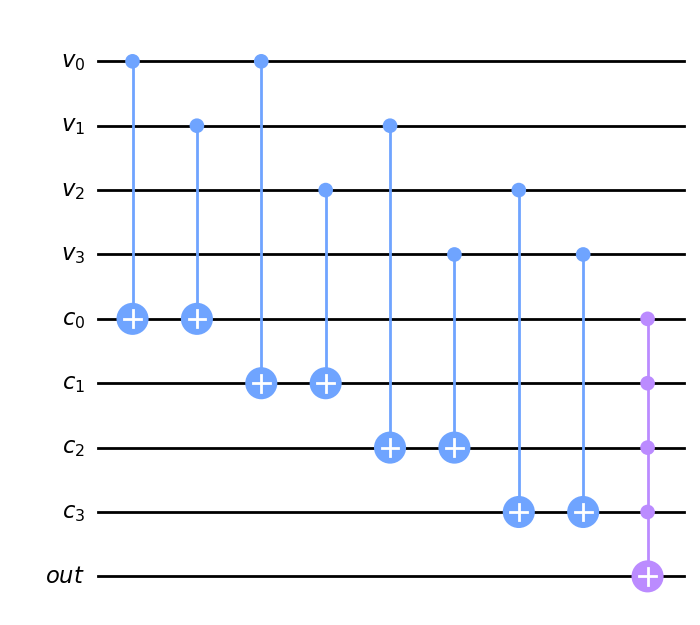

In [13]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
# from the previous exercise
for i, clause in enumerate(clause_list):
    XOR(qc, var_qubits[clause[0]], var_qubits[clause[1]], clause_qubits[i])

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw('mpl')

To recap, we have 3 registers:

* One register which stores our sudoku variables (`x=v3,v2,v1,v0`)
* One register that stores our clauses (this starts in the state $|0000\rangle$ which we'll abbreviate to $|0\rangle$)
* And one qubit ($|out_0\rangle$) that we've been using to store the output of our checking circuit. 

For the oracle, we need the transformation:
$$U_\omega |x\rangle |0\rangle |out_0 \rangle =|x\rangle |0\rangle |out_0 \oplus f(x) \rangle $$

<div class='alert alert-block alert-warning'>
Apply the oracle of the Grover's algorithm.
    
Note that we need to guarantee the bits in the second register are always returned to the state $|0000\rangle$ after the computation. Therefore we will require *uncomputation*.
</div>

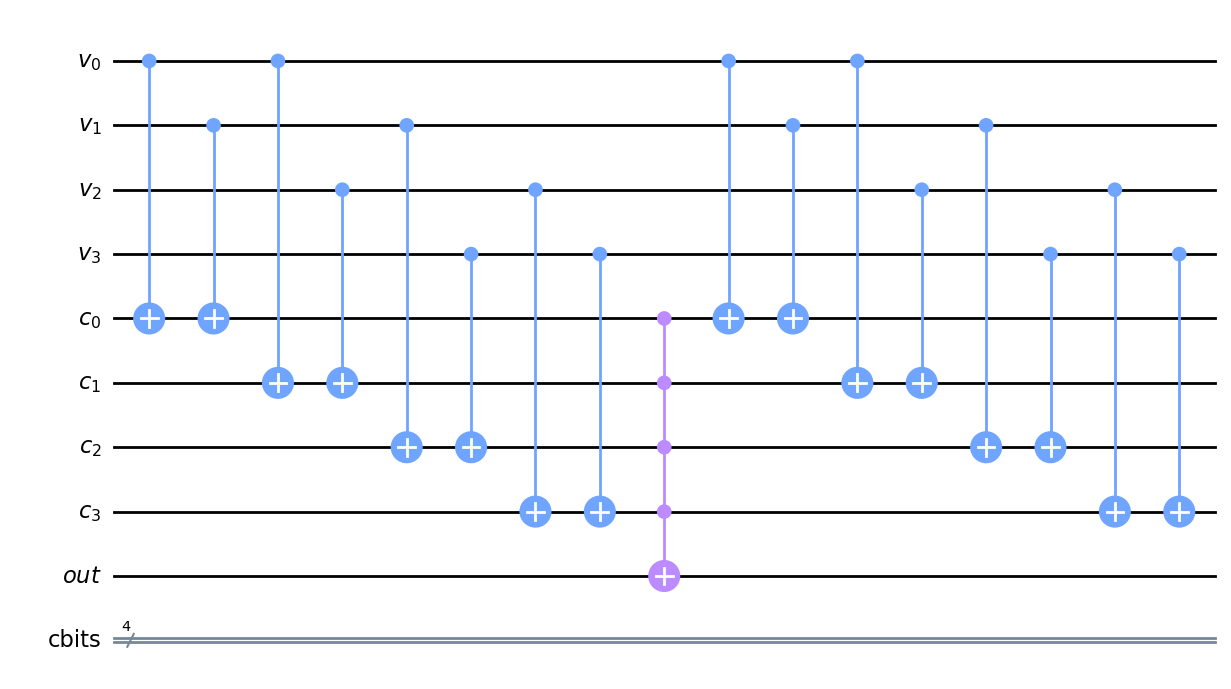

In [14]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    for i, clause in enumerate(clause_list):
        XOR(qc, var_qubits[clause[0]], var_qubits[clause[1]], clause_qubits[i])
    
    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    for i, clause in enumerate(clause_list):
        XOR(qc, var_qubits[clause[0]], var_qubits[clause[1]], clause_qubits[i])


sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw('mpl')

In summary, the circuit above performs:

$$ U_\omega |x\rangle|0\rangle |out_0\rangle = 
\left\{
    \begin{array}{l}
      |x\rangle|0\rangle |out_0\rangle  & \mbox{for } x \neq \omega \\
      |x\rangle|0\rangle \otimes X|out_0\rangle  & \mbox{for } x = \omega
    \end{array}
  \right.$$
  
and if the initial state of $|out_0\rangle=|-\rangle$:
$$ U_\omega |x\rangle|0\rangle |-\rangle = 
\left\{
    \begin{array}{l}
      |x\rangle|0\rangle |-\rangle  & \mbox{for } x \neq \omega \\
      -|x\rangle|0\rangle|-\rangle  & \mbox{for } x = \omega
    \end{array}
  \right.$$

<div class='alert alert-block alert-warning'>
Now put this oracle into Grover's algorithm. Find the optimal number of iterations. 
    
Tip: the out qubit should be initialized with state $|-\rangle$. You can use the function [`initialize`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.initialize.html) for it.
    
</div>

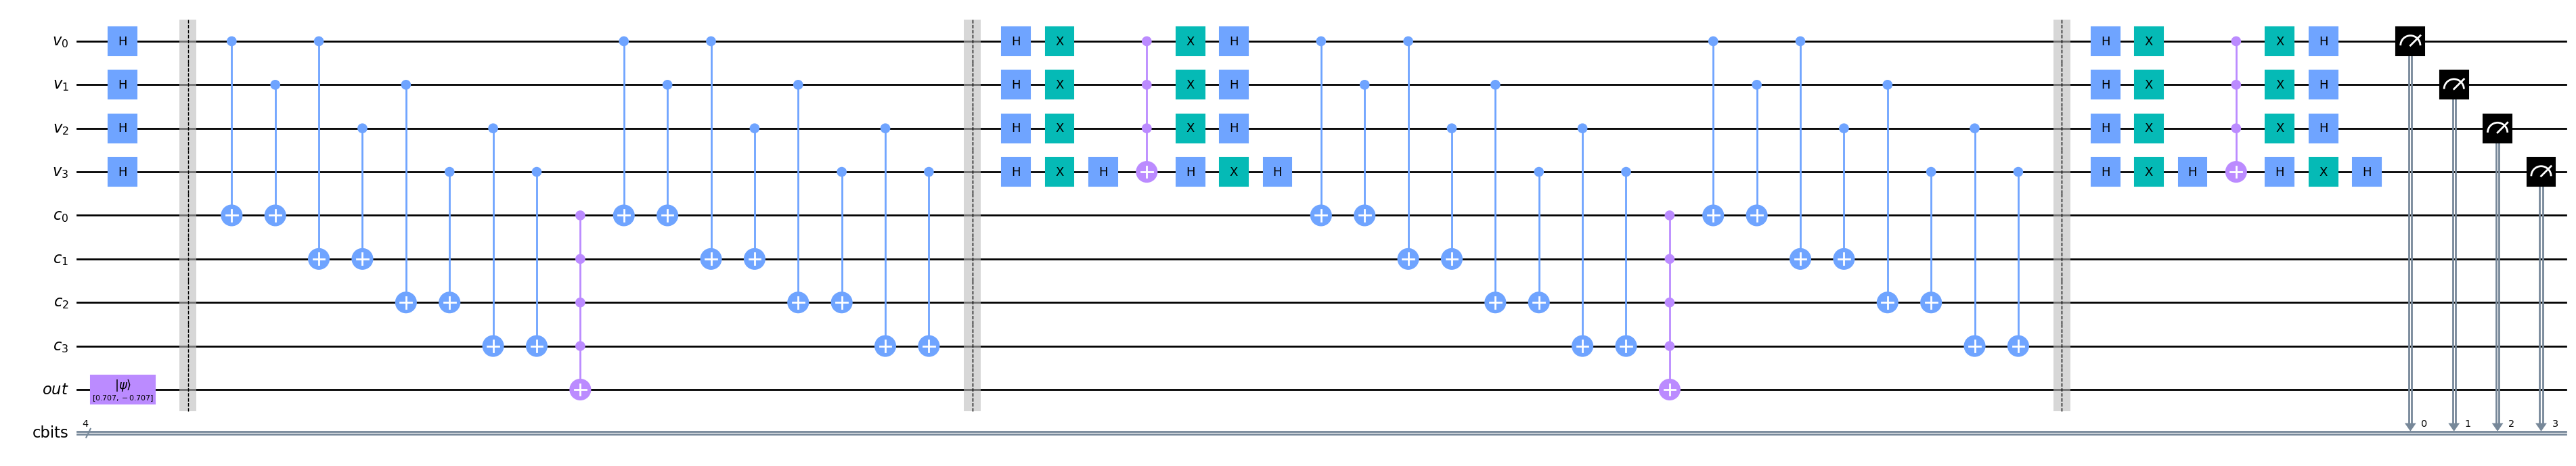

In [55]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1/sqrt(2), -1/sqrt(2)], output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits[0])
qc.h(var_qubits[1])
qc.h(var_qubits[2])
qc.h(var_qubits[3])


qc.barrier()  # for visual separation

# Iterations 
for _ in range(it(16,2)):
    # Apply oracle
    sudoku_oracle(qc, clause_list, clause_qubits)

    qc.barrier()  # for visual separation
    # Apply diffuser
    qc.h(var_qubits)
    qc.x(var_qubits)
    qc.h(var_qubits[3])
    qc.mct(var_qubits[0:3], var_qubits[3])
    qc.h(var_qubits[3])
    qc.x(var_qubits)
    qc.h(var_qubits)

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw('mpl',fold=-1)

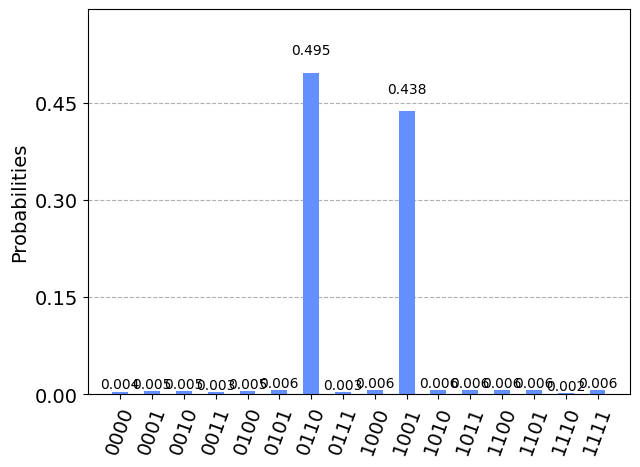

In [56]:
# Simulate and plot results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

## 3. Advanced circuits <a id="ac"></a>

### A. Opaque gates  and Composite gates <a id="ogcg"></a>

To create a gate one need to define the following:

In [26]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

Then one can simply stick a gate to any bigger circuit, using the function `append()`. 

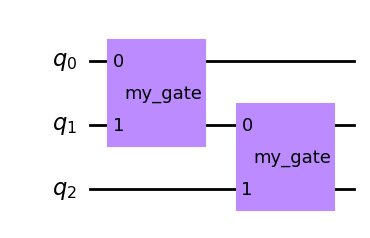

In [27]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw('mpl')

Here we create new gate, but there is no information about what it is doing or how it should decompose.

However, we can turn any circuit into a gate. 

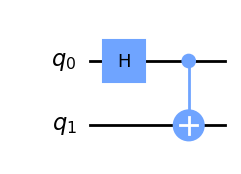

In [39]:
qr = QuantumRegister(2, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0],qr[1])
circ.draw('mpl')

In [40]:
bell=circ.to_gate()
bell.name="bell"

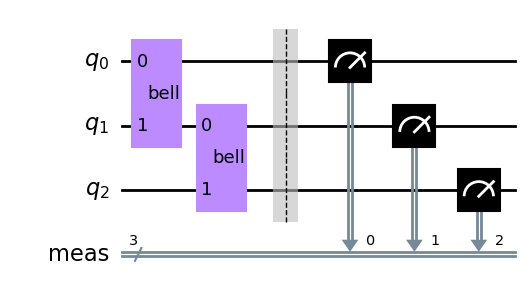

In [41]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(bell, [qr[0], qr[1]])
circ.append(bell, [qr[1], qr[2]])

circ.measure_all()

circ.draw('mpl')

When desired, or before compilation, sub-circuits will be decomposed via the `decompose`method.

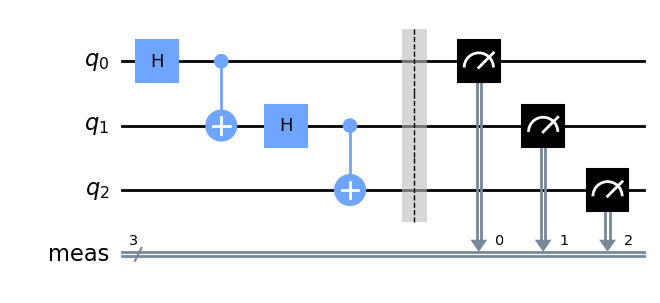

In [42]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw('mpl')

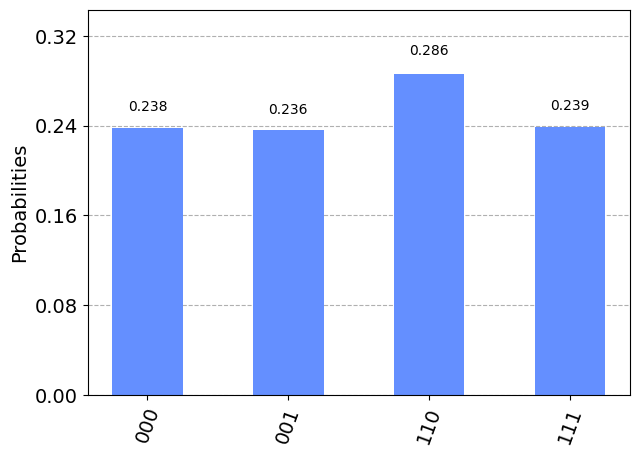

In [43]:
# Simulate and plot results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(circ, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

### B. Parameterised gates <a id="parag"></a>

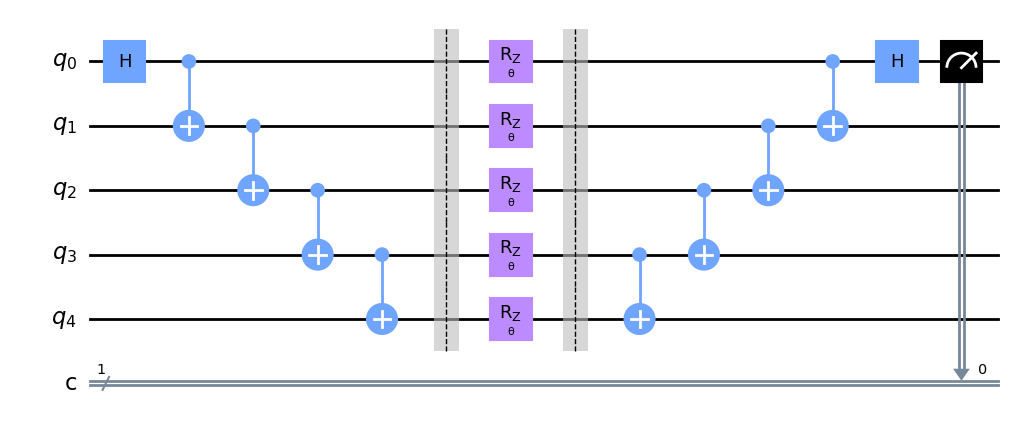

In [57]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

We can inspect the circuit's parameters

In [58]:
print(qc.parameters)

ParameterView([Parameter(θ)])


All circuit parameters must be bound before sending the circuit to a backend. This can be done as follows:

* The `bind_parameters` method accepts a dictionary mapping `Parameter`s to values, and returns a new circuit with each parameter replaced by its corresponding value. Partial binding is supported, in which case the returned circuit will be parameterized by any `Parameter`s that were not mapped to a value.


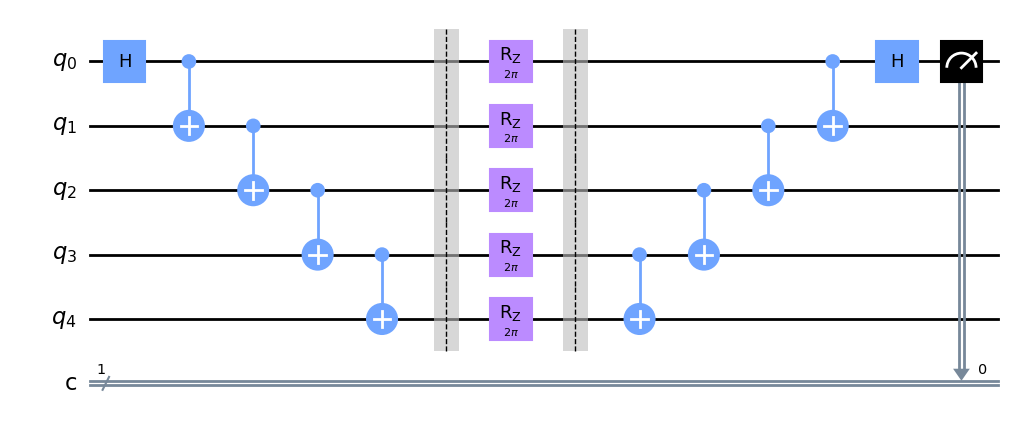

In [61]:
theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

circuits[-1].draw('mpl')

In [62]:
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

In the example circuit, we apply a global $R_z(\theta)$ rotation on a five-qubit entangled state. Therefore we expect to see an oscillation in qubit-$0$ at $5\theta$.

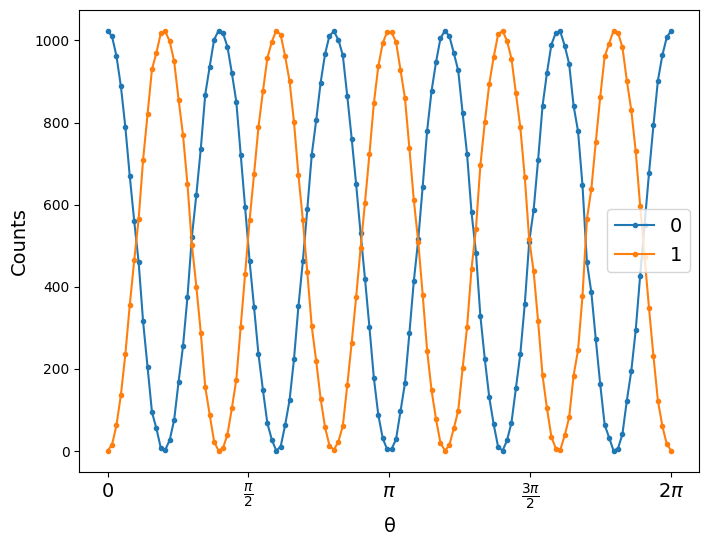

In [63]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1') 

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

Rewrite the Grover's algorithm with $U_\omega$ and $U_s$ as  opaque gates. 

In [73]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

sudoku_oracle(qc, clause_list, clause_qubits)

Uw = qc.to_gate()
Uw.name = "U$_w$"

In [74]:
var_qubits = QuantumRegister(4, name='v')
qc = QuantumCircuit(var_qubits)
qc.h(var_qubits)
qc.x(var_qubits)
qc.h(var_qubits[3])
qc.mct(var_qubits[0:3], var_qubits[3])
qc.h(var_qubits[3])
qc.x(var_qubits)
qc.h(var_qubits)

Us = qc.to_gate()
Us.name = "U$_s$"

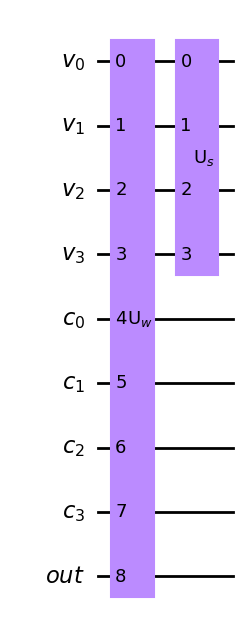

In [75]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

qc.append(Uw, [var_qubits[0], var_qubits[1], var_qubits[2], var_qubits[3], clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])
qc.append(Us, [var_qubits[0], var_qubits[1], var_qubits[2], var_qubits[3]])

qc.draw('mpl')

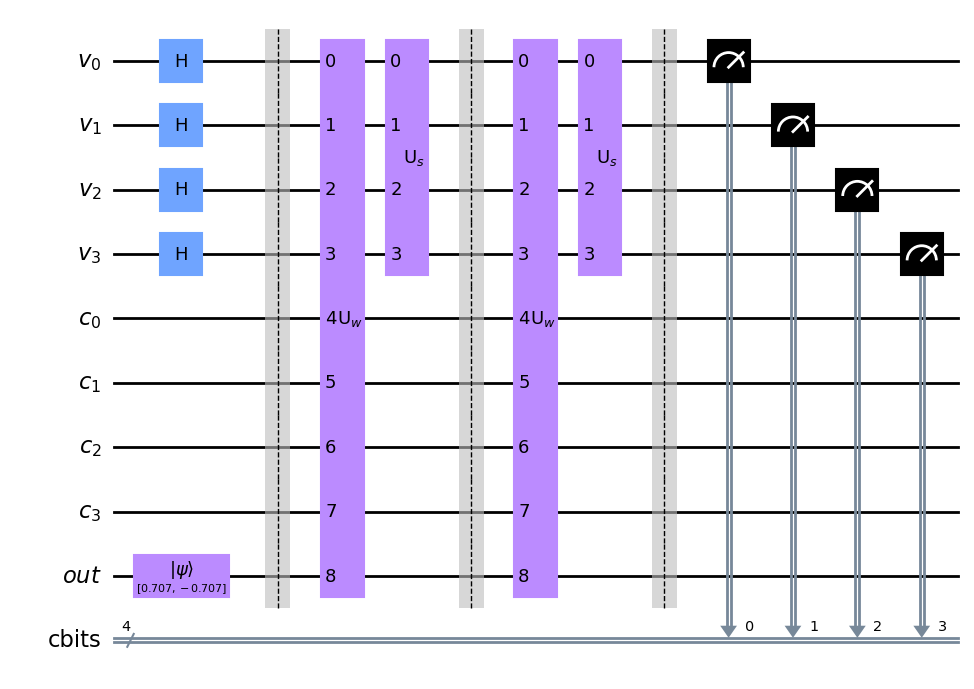

In [76]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1/sqrt(2), -1/sqrt(2)], output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits[0])
qc.h(var_qubits[1])
qc.h(var_qubits[2])
qc.h(var_qubits[3])


qc.barrier()  # for visual separation

for _ in range(it(16, 2)):
    qc.append(Uw, [var_qubits[0], var_qubits[1], var_qubits[2], var_qubits[3], clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])
    qc.append(Us, [var_qubits[0], var_qubits[1], var_qubits[2], var_qubits[3]])
    qc.barrier()  # for visual separation

qc.measure(var_qubits, cbits)

qc.draw('mpl')

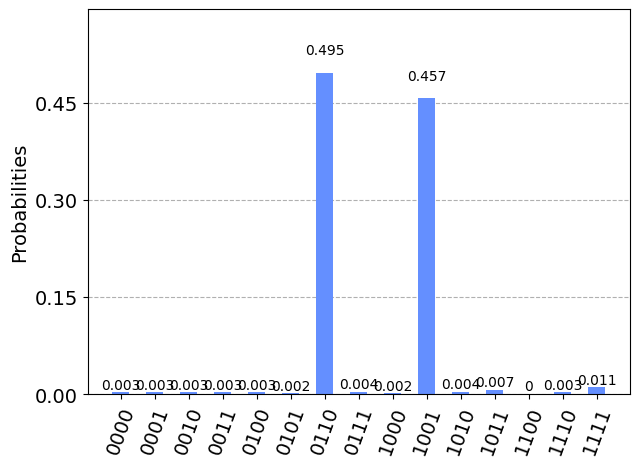

In [96]:
# Simulate and plot results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(qc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

**Refs:**
* [Grover's algorithm - Qiskit](https://qiskit.org/textbook/ch-algorithms/grover.html)
* [Theory of Grover's search algorithm - microsoft](https://learn.microsoft.com/en-us/azure/quantum/concepts-grovers#optimal-number-of-iterations)
* [Qiskit tutorials - Advanced Circuit](https://lab.quantum-computing.ibm.com/user/619e18c568476dda8d8a9ff5/lab/tree/qiskit-tutorials/qiskit/tutorials/circuits_advanced/01_advanced_circuits.ipynb)
